<a href="https://colab.research.google.com/github/mttga/mttga.github.io/blob/main/pqn_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jax PureGPU Training of PQN in MinAtar

In this section we're going to train PQN in a single Pure-GPU regime using Jax. We're going to use gymnax version of Minatar in order to run the vectorized environment in gpu. Thanks to Jax vectorization, we will be able to run multiple runs with different random seeds in parallel. The implementation is copied from the original PQN repository: https://github.com/mttga/purejaxql/blob/main/purejaxql/pqn_gymnax.py

In [2]:
# make sure to install gymanx
!pip install gymnax==0.0.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.4/92.4 kB 3.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827692 sha256=40ec3b96052fec1f1990a291a843d304ca470fc885cffc11af522398c8fbe835
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [7]:
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
from typing import Any
import gymnax

import wandb
import chex
import optax
import flax.linen as nn
from flax.training.train_state import TrainState
from gymnax.wrappers.purerl import FlattenObservationWrapper, LogWrapper


class CNN(nn.Module):

    norm_type: str = "layer_norm"

    @nn.compact
    def __call__(self, x: jnp.ndarray, train: bool):

        if self.norm_type == "layer_norm":
            normalize = lambda x: nn.LayerNorm()(x)
        elif self.norm_type == "batch_norm":
            normalize = lambda x: nn.BatchNorm(use_running_average=not train)(x)
        else:
            normalize = lambda x: x

        x = nn.Conv(
            16,
            kernel_size=(3, 3),
            strides=1,
            padding="VALID",
            kernel_init=nn.initializers.he_normal(),
        )(x)
        x = normalize(x)
        x = nn.relu(x)
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(128, kernel_init=nn.initializers.he_normal())(x)
        x = normalize(x)
        x = nn.relu(x)
        return x


class QNetwork(nn.Module):
    action_dim: int
    norm_type: str = "layer_norm"
    norm_input: bool = False

    @nn.compact
    def __call__(self, x: jnp.ndarray, train: bool):
        if self.norm_input:
            x = nn.BatchNorm(use_running_average=not train)(x)
        else:
            # dummy normalize input for global compatibility
            x_dummy = nn.BatchNorm(use_running_average=not train)(x)
            x = x / 255.0
        x = CNN(norm_type=self.norm_type)(x, train)
        x = nn.Dense(self.action_dim)(x)
        return x


@chex.dataclass(frozen=True)
class Transition:
    obs: chex.Array
    action: chex.Array
    reward: chex.Array
    done: chex.Array
    next_obs: chex.Array
    q_val: chex.Array


class CustomTrainState(TrainState):
    batch_stats: Any
    timesteps: int = 0
    n_updates: int = 0
    grad_steps: int = 0


def make_train(config):

    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )

    config["NUM_UPDATES_DECAY"] = (
        config["TOTAL_TIMESTEPS_DECAY"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )

    assert (config["NUM_STEPS"] * config["NUM_ENVS"]) % config[
        "NUM_MINIBATCHES"
    ] == 0, "NUM_MINIBATCHES must divide NUM_STEPS*NUM_ENVS"

    env, env_params = gymnax.make(config["ENV_NAME"])
    env = LogWrapper(env)
    config["TEST_NUM_STEPS"] = env_params.max_steps_in_episode

    vmap_reset = lambda n_envs: lambda rng: jax.vmap(env.reset, in_axes=(0, None))(
        jax.random.split(rng, n_envs), env_params
    )
    vmap_step = lambda n_envs: lambda rng, env_state, action: jax.vmap(
        env.step, in_axes=(0, 0, 0, None)
    )(jax.random.split(rng, n_envs), env_state, action, env_params)

    # epsilon-greedy exploration
    def eps_greedy_exploration(rng, q_vals, eps):
        rng_a, rng_e = jax.random.split(
            rng
        )  # a key for sampling random actions and one for picking
        greedy_actions = jnp.argmax(q_vals, axis=-1)
        chosed_actions = jnp.where(
            jax.random.uniform(rng_e, greedy_actions.shape)
            < eps,  # pick the actions that should be random
            jax.random.randint(
                rng_a, shape=greedy_actions.shape, minval=0, maxval=q_vals.shape[-1]
            ),  # sample random actions,
            greedy_actions,
        )
        return chosed_actions

    def train(rng):

        original_rng = rng[0]

        eps_scheduler = optax.linear_schedule(
            config["EPS_START"],
            config["EPS_FINISH"],
            (config["EPS_DECAY"]) * config["NUM_UPDATES_DECAY"],
        )

        lr_scheduler = optax.linear_schedule(
            init_value=config["LR"],
            end_value=1e-20,
            transition_steps=(config["NUM_UPDATES_DECAY"])
            * config["NUM_MINIBATCHES"]
            * config["NUM_EPOCHS"],
        )
        lr = lr_scheduler if config.get("LR_LINEAR_DECAY", False) else config["LR"]

        # INIT NETWORK AND OPTIMIZER
        network = QNetwork(
            action_dim=env.action_space(env_params).n,
            norm_type=config["NORM_TYPE"],
            norm_input=config.get("NORM_INPUT", False),
        )

        def create_agent(rng):
            init_x = jnp.zeros((1, *env.observation_space(env_params).shape))
            network_variables = network.init(rng, init_x, train=False)
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.radam(learning_rate=lr),
            )

            train_state = CustomTrainState.create(
                apply_fn=network.apply,
                params=network_variables["params"],
                batch_stats=network_variables["batch_stats"],
                tx=tx,
            )
            return train_state

        rng, _rng = jax.random.split(rng)
        train_state = create_agent(rng)

        # TRAINING LOOP
        def _update_step(runner_state, unused):

            train_state, expl_state, test_metrics, rng = runner_state

            # SAMPLE PHASE
            def _step_env(carry, _):
                last_obs, env_state, rng = carry
                rng, rng_a, rng_s = jax.random.split(rng, 3)
                q_vals = network.apply(
                    {
                        "params": train_state.params,
                        "batch_stats": train_state.batch_stats,
                    },
                    last_obs,
                    train=False,
                )

                # different eps for each env
                _rngs = jax.random.split(rng_a, config["NUM_ENVS"])
                eps = jnp.full(config["NUM_ENVS"], eps_scheduler(train_state.n_updates))
                new_action = jax.vmap(eps_greedy_exploration)(_rngs, q_vals, eps)

                new_obs, new_env_state, reward, new_done, info = vmap_step(
                    config["NUM_ENVS"]
                )(rng_s, env_state, new_action)

                transition = Transition(
                    obs=last_obs,
                    action=new_action,
                    reward=config.get("REW_SCALE", 1)*reward,
                    done=new_done,
                    next_obs=new_obs,
                    q_val=q_vals,
                )
                return (new_obs, new_env_state, rng), (transition, info)

            # step the env
            rng, _rng = jax.random.split(rng)
            (*expl_state, rng), (transitions, infos) = jax.lax.scan(
                _step_env,
                (*expl_state, _rng),
                None,
                config["NUM_STEPS"],
            )
            expl_state = tuple(expl_state)

            train_state = train_state.replace(
                timesteps=train_state.timesteps
                + config["NUM_STEPS"] * config["NUM_ENVS"]
            )  # update timesteps count

            last_q = network.apply(
                {
                    "params": train_state.params,
                    "batch_stats": train_state.batch_stats,
                },
                transitions.next_obs[-1],
                train=False,
            )
            last_q = jnp.max(last_q, axis=-1)

            def _get_target(lambda_returns_and_next_q, transition):
                lambda_returns, next_q = lambda_returns_and_next_q
                target_bootstrap = (
                    transition.reward + config["GAMMA"] * (1 - transition.done) * next_q
                )
                delta = lambda_returns - next_q
                lambda_returns = (
                    target_bootstrap + config["GAMMA"] * config["LAMBDA"] * delta
                )
                lambda_returns = (
                    1 - transition.done
                ) * lambda_returns + transition.done * transition.reward
                next_q = jnp.max(transition.q_val, axis=-1)
                return (lambda_returns, next_q), lambda_returns

            last_q = last_q * (1 - transitions.done[-1])
            lambda_returns = transitions.reward[-1] + config["GAMMA"] * last_q
            _, targets = jax.lax.scan(
                _get_target,
                (lambda_returns, last_q),
                jax.tree_map(lambda x: x[:-1], transitions),
                reverse=True,
            )
            lambda_targets = jnp.concatenate((targets, lambda_returns[np.newaxis]))

            # NETWORKS UPDATE
            def _learn_epoch(carry, _):
                train_state, rng = carry

                def _learn_phase(carry, minibatch_and_target):

                    train_state, rng = carry
                    minibatch, target = minibatch_and_target

                    def _loss_fn(params):
                        q_vals, updates = network.apply(
                            {"params": params, "batch_stats": train_state.batch_stats},
                            minibatch.obs,
                            train=True,
                            mutable=["batch_stats"],
                        )  # (batch_size*2, num_actions)

                        chosen_action_qvals = jnp.take_along_axis(
                            q_vals,
                            jnp.expand_dims(minibatch.action, axis=-1),
                            axis=-1,
                        ).squeeze(axis=-1)

                        loss = 0.5 * jnp.square(chosen_action_qvals - target).mean()

                        return loss, (updates, chosen_action_qvals)

                    (loss, (updates, qvals)), grads = jax.value_and_grad(
                        _loss_fn, has_aux=True
                    )(train_state.params)
                    train_state = train_state.apply_gradients(grads=grads)
                    train_state = train_state.replace(
                        grad_steps=train_state.grad_steps + 1,
                        batch_stats=updates["batch_stats"],
                    )
                    return (train_state, rng), (loss, qvals)

                def preprocess_transition(x, rng):
                    x = x.reshape(
                        -1, *x.shape[2:]
                    )  # num_steps*num_envs (batch_size), ...
                    x = jax.random.permutation(rng, x)  # shuffle the transitions
                    x = x.reshape(
                        config["NUM_MINIBATCHES"], -1, *x.shape[1:]
                    )  # num_mini_updates, batch_size/num_mini_updates, ...
                    return x

                rng, _rng = jax.random.split(rng)
                minibatches = jax.tree_util.tree_map(
                    lambda x: preprocess_transition(x, _rng), transitions
                )  # num_actors*num_envs (batch_size), ...
                targets = jax.tree_map(
                    lambda x: preprocess_transition(x, _rng), lambda_targets
                )

                rng, _rng = jax.random.split(rng)
                (train_state, rng), (loss, qvals) = jax.lax.scan(
                    _learn_phase, (train_state, rng), (minibatches, targets)
                )

                return (train_state, rng), (loss, qvals)

            rng, _rng = jax.random.split(rng)
            (train_state, rng), (loss, qvals) = jax.lax.scan(
                _learn_epoch, (train_state, rng), None, config["NUM_EPOCHS"]
            )

            train_state = train_state.replace(n_updates=train_state.n_updates + 1)
            metrics = {
                "env_step": train_state.timesteps,
                "update_steps": train_state.n_updates,
                "env_frame": train_state.timesteps * env.observation_space(env_params).shape[-1],
                "grad_steps": train_state.grad_steps,
                "td_loss": loss.mean(),
                "qvals": qvals.mean(),
            }
            metrics.update({k: v.mean() for k, v in infos.items()})

            if config.get("TEST_DURING_TRAINING", False):
                rng, _rng = jax.random.split(rng)
                test_metrics = jax.lax.cond(
                    train_state.n_updates
                    % int(config["NUM_UPDATES"] * config["TEST_INTERVAL"])
                    == 0,
                    lambda _: get_test_metrics(train_state, _rng),
                    lambda _: test_metrics,
                    operand=None,
                )
                metrics.update({f"test_{k}": v for k, v in test_metrics.items()})

            # report on wandb if required
            if config["WANDB_MODE"] != "disabled":

                def callback(metrics, original_rng):
                    if config.get("WANDB_LOG_ALL_SEEDS", False):
                        metrics.update(
                            {
                                f"rng{int(original_rng)}/{k}": v
                                for k, v in metrics.items()
                            }
                        )
                    wandb.log(metrics, step=metrics["update_steps"])

                jax.debug.callback(callback, metrics, original_rng)

            runner_state = (train_state, tuple(expl_state), test_metrics, rng)

            return runner_state, metrics

        def get_test_metrics(train_state, rng):

            if not config.get("TEST_DURING_TRAINING", False):
                return None

            def _env_step(carry, _):
                env_state, last_obs, rng = carry
                rng, _rng = jax.random.split(rng)
                q_vals = network.apply(
                    {
                        "params": train_state.params,
                        "batch_stats": train_state.batch_stats,
                    },
                    last_obs,
                    train=False,
                )
                eps = jnp.full(config["TEST_NUM_ENVS"], config["EPS_TEST"])
                action = jax.vmap(eps_greedy_exploration)(
                    jax.random.split(_rng, config["TEST_NUM_ENVS"]), q_vals, eps
                )
                new_obs, new_env_state, reward, done, info = vmap_step(
                    config["TEST_NUM_ENVS"]
                )(_rng, env_state, action)
                return (new_env_state, new_obs, rng), info

            rng, _rng = jax.random.split(rng)
            init_obs, env_state = vmap_reset(config["TEST_NUM_ENVS"])(_rng)

            _, infos = jax.lax.scan(
                _env_step, (env_state, init_obs, _rng), None, config["TEST_NUM_STEPS"]
            )
            # return mean of done infos
            done_infos = jax.tree_map(
                lambda x: jnp.nanmean(
                    jnp.where(
                        infos["returned_episode"],
                        x,
                        jnp.nan,
                    )
                ),
                infos,
            )
            return done_infos

        rng, _rng = jax.random.split(rng)
        test_metrics = get_test_metrics(train_state, _rng)

        rng, _rng = jax.random.split(rng)
        expl_state = vmap_reset(config["NUM_ENVS"])(_rng)

        # train
        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, expl_state, test_metrics, _rng)

        runner_state, metrics = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )

        return {"runner_state": runner_state, "metrics": metrics}

    return train

In [12]:
config = {
    "TOTAL_TIMESTEPS": 1e7,
    "TOTAL_TIMESTEPS_DECAY": 1e7,
    "NUM_ENVS": 128,
    "NUM_STEPS": 32,
    "EPS_START": 1.0,
    "EPS_FINISH": 0.05,
    "EPS_DECAY": 0.1,
    "NUM_MINIBATCHES": 32,
    "NUM_EPOCHS": 2,
    "NORM_TYPE": "layer_norm",
    "LR": 0.0005,
    "MAX_GRAD_NORM": 10,
    "LR_LINEAR_DECAY": True,
    "GAMMA": 0.99,
    "LAMBDA": 0.65,

    # env specific
    "ENV_NAME": "Asterix-MinAtar",
    "ENV_KWARGS": {},

    # evaluation
    "TEST_DURING_TRAINING": True,
    "TEST_INTERVAL": 0.05,
    "TEST_NUM_ENVS": 128,
    "EPS_TEST": 0.0,

    # log
    "WANDB_MODE": "disabled",
}

In [23]:
import time

seed = 0
num_seeds = 3 # modify to run more runs in parallel (might affect time performances depending on the runtime)

rng = jax.random.PRNGKey(seed)

t0 = time.time()
rngs = jax.random.split(rng, num_seeds)
train_vjit = jax.jit(jax.vmap(make_train(config)))
outs = jax.block_until_ready(train_vjit(rngs))
print(f"Took {time.time()-t0} seconds to complete.")

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
<ipython-input-7-b0b89302f950>:394: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) 

Took 234.6776704788208 seconds to complete.


Let's plot the returns collected by the exploratory policy (eps-greedy) and the greedy policy tested during training for each seed used for training.

<ipython-input-24-fde86cf33b23>:4: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  seed_metrics = jax.tree_map(lambda x: x[i], outs['metrics'])


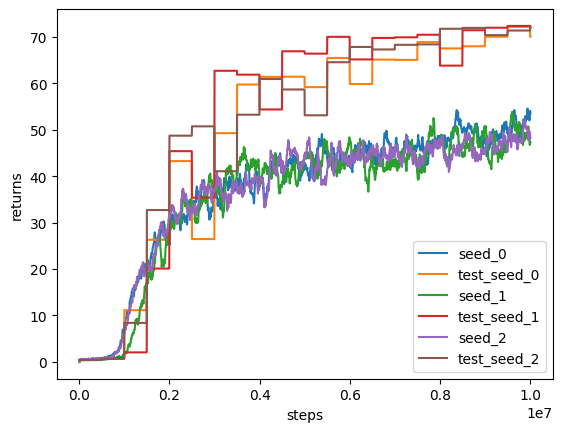

In [24]:
from matplotlib import pyplot as plt

for i in range(num_seeds):
  seed_metrics = jax.tree_map(lambda x: x[i], outs['metrics'])
  env_steps = seed_metrics['env_step']
  plt.plot(env_steps, seed_metrics['returned_episode_returns'], label=f'seed_{i}')
  plt.plot(env_steps, seed_metrics['test_returned_episode_returns'], label=f'test_seed_{i}')

plt.xlabel('steps')
plt.ylabel('returns')
plt.legend()

# Pytorch training of PQN in Atari Pong

Now let's now run PQN with Pytorch on a simple Atari game like Pong! In this case we will use the Cleanrl implementation: https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/pqn_atari_envpool.py

Vectorization of Atari is done with Envpool and occurs on the CPU. In a modern workstation should take around 2 minutes. In Colab depending on the rentime should take about 8-9 minutes to obtain a good enough policy and about 10-12 to have an always wining agent. Mind that you can find the original and faster Jax-based implementation of PQN at https://github.com/mttga/purejaxql/blob/main/purejaxql/pqn_atari.py, which also provides an XLA Envpool interface for compiling the entire code (gpu-training and cpu-environment sampling) with Jax.

In [5]:
!pip install gymnasium[atari]
!pip install envpool
!pip install tyro
!pip install gym==0.23.1  # Because it is compatible with Recorder from pqn implementation

Now we will use the [implementation from CleanRL](https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/pqn_atari_envpool.py) for running PQN on Atari's Pong using Pytorch.


In [26]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/pqn/#pqn_atari_envpoolpy
import os
import random
import time
from collections import deque
from dataclasses import dataclass

import envpool
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter


@dataclass
class Args:
    exp_name: str = 'pqn_atari_envpool'
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "cleanRL"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""

    # Algorithm specific arguments
    env_id: str = "Breakout-v5"
    """the id of the environment"""
    total_timesteps: int = 10000000
    """total timesteps of the experiments"""
    learning_rate: float = 2.5e-4
    """the learning rate of the optimizer"""
    num_envs: int = 8
    """the number of parallel game environments"""
    num_steps: int = 128
    """the number of steps to run in each environment per policy rollout"""
    anneal_lr: bool = True
    """Toggle learning rate annealing for policy and value networks"""
    gamma: float = 0.99
    """the discount factor gamma"""
    num_minibatches: int = 4
    """the number of mini-batches"""
    update_epochs: int = 4
    """the K epochs to update the policy"""
    max_grad_norm: float = 10.0
    """the maximum norm for the gradient clipping"""
    start_e: float = 1
    """the starting epsilon for exploration"""
    end_e: float = 0.01
    """the ending epsilon for exploration"""
    exploration_fraction: float = 0.10
    """the fraction of `total_timesteps` it takes from start_e to end_e"""
    q_lambda: float = 0.65
    """the lambda for the Q-Learning algorithm"""

    # to be filled in runtime
    batch_size: int = 0
    """the batch size (computed in runtime)"""
    minibatch_size: int = 0
    """the mini-batch size (computed in runtime)"""
    num_iterations: int = 0
    """the number of iterations (computed in runtime)"""


class RecordEpisodeStatistics(gym.Wrapper):
    def __init__(self, env, deque_size=100):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.episode_returns = None
        self.episode_lengths = None

    def reset(self, **kwargs):
        observations = super().reset(**kwargs)
        self.episode_returns = np.zeros(self.num_envs, dtype=np.float32)
        self.episode_lengths = np.zeros(self.num_envs, dtype=np.int32)
        self.lives = np.zeros(self.num_envs, dtype=np.int32)
        self.returned_episode_returns = np.zeros(self.num_envs, dtype=np.float32)
        self.returned_episode_lengths = np.zeros(self.num_envs, dtype=np.int32)
        return observations

    def step(self, action):
        observations, rewards, dones, infos = super().step(action)
        self.episode_returns += infos["reward"]
        self.episode_lengths += 1
        self.returned_episode_returns[:] = self.episode_returns
        self.returned_episode_lengths[:] = self.episode_lengths
        self.episode_returns *= 1 - infos["terminated"]
        self.episode_lengths *= 1 - infos["terminated"]
        infos["r"] = self.returned_episode_returns
        infos["l"] = self.returned_episode_lengths
        return (
            observations,
            rewards,
            dones,
            infos,
        )


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride=4)),
            nn.LayerNorm([32, 20, 20]),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride=2)),
            nn.LayerNorm([64, 9, 9]),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.LayerNorm([64, 7, 7]),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(3136, 512)),
            nn.LayerNorm(512),
            nn.ReLU(),
            layer_init(nn.Linear(512, env.single_action_space.n)),
        )

    def forward(self, x):
        return self.network(x / 255.0)


def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)


def main(args):
    args.batch_size = int(args.num_envs * args.num_steps)
    args.minibatch_size = int(args.batch_size // args.num_minibatches)
    args.num_iterations = args.total_timesteps // args.batch_size
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )

    # TRY NOT TO MODIFY: seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic

    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

    # env setup
    envs = envpool.make(
        args.env_id,
        env_type="gym",
        num_envs=args.num_envs,
        episodic_life=True,
        reward_clip=True,
        seed=args.seed,
    )
    envs.num_envs = args.num_envs
    envs.single_action_space = envs.action_space
    envs.single_observation_space = envs.observation_space
    envs = RecordEpisodeStatistics(envs)
    assert isinstance(envs.action_space, gym.spaces.Discrete), "only discrete action space is supported"

    q_network = QNetwork(envs).to(device)
    optimizer = optim.RAdam(q_network.parameters(), lr=args.learning_rate)

    # ALGO Logic: Storage setup
    obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
    actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
    rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
    dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
    values = torch.zeros((args.num_steps, args.num_envs)).to(device)
    avg_returns = deque(maxlen=20)

    # TRY NOT TO MODIFY: start the game
    global_step = 0
    start_time = time.time()
    next_obs = torch.Tensor(envs.reset()).to(device)
    next_done = torch.zeros(args.num_envs).to(device)

    for iteration in range(1, args.num_iterations + 1):
        # Annealing the rate if instructed to do so.
        if args.anneal_lr:
            frac = 1.0 - (iteration - 1.0) / args.num_iterations
            lrnow = frac * args.learning_rate
            optimizer.param_groups[0]["lr"] = lrnow

        for step in range(0, args.num_steps):
            global_step += args.num_envs
            obs[step] = next_obs
            dones[step] = next_done

            epsilon = linear_schedule(args.start_e, args.end_e, args.exploration_fraction * args.total_timesteps, global_step)

            random_actions = torch.randint(0, envs.single_action_space.n, (args.num_envs,)).to(device)
            with torch.no_grad():
                q_values = q_network(next_obs)
                max_actions = torch.argmax(q_values, dim=1)
                values[step] = q_values[torch.arange(args.num_envs), max_actions].flatten()

            explore = torch.rand((args.num_envs,)).to(device) < epsilon
            action = torch.where(explore, random_actions, max_actions)
            actions[step] = action

            # TRY NOT TO MODIFY: execute the game and log data.
            next_obs, reward, next_done, info = envs.step(action.cpu().numpy())
            rewards[step] = torch.tensor(reward).to(device).view(-1)
            next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

            for idx, d in enumerate(next_done):
                if d and info["lives"][idx] == 0:
                    print(f"global_step={global_step}, episodic_return={info['r'][idx]}")
                    avg_returns.append(info["r"][idx])
                    writer.add_scalar("charts/avg_episodic_return", np.average(avg_returns), global_step)
                    writer.add_scalar("charts/episodic_return", info["r"][idx], global_step)
                    writer.add_scalar("charts/episodic_length", info["l"][idx], global_step)

        # Compute Q(lambda) targets
        with torch.no_grad():
            returns = torch.zeros_like(rewards).to(device)
            for t in reversed(range(args.num_steps)):
                if t == args.num_steps - 1:
                    next_value, _ = torch.max(q_network(next_obs), dim=-1)
                    nextnonterminal = 1.0 - next_done
                    returns[t] = rewards[t] + args.gamma * next_value * nextnonterminal
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    next_value = values[t + 1]
                    returns[t] = rewards[t] + args.gamma * (
                        args.q_lambda * returns[t + 1] + (1 - args.q_lambda) * next_value * nextnonterminal
                    )

        # flatten the batch
        b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
        b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
        b_returns = returns.reshape(-1)

        # Optimizing the Q-network
        b_inds = np.arange(args.batch_size)
        for epoch in range(args.update_epochs):
            np.random.shuffle(b_inds)
            for start in range(0, args.batch_size, args.minibatch_size):
                end = start + args.minibatch_size
                mb_inds = b_inds[start:end]

                old_val = q_network(b_obs[mb_inds]).gather(1, b_actions[mb_inds].unsqueeze(-1).long()).squeeze()
                loss = F.mse_loss(b_returns[mb_inds], old_val)

                # optimize the model
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(q_network.parameters(), args.max_grad_norm)
                optimizer.step()

        writer.add_scalar("losses/td_loss", loss, global_step)
        writer.add_scalar("losses/q_values", old_val.mean().item(), global_step)
        print("SPS:", int(global_step / (time.time() - start_time)))
        writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

    envs.close()
    writer.close()

    # Record the agent's performance
    from moviepy.editor import ImageSequenceClip

    def record_agent_performance(q_network, env_id, num_episodes=1):
        output_path=env_id+".mp4"
        env = envpool.make(env_id, env_type="gym", num_envs=1)
        frames = []

        for episode in range(num_episodes):
            obs = env.reset()
            print(obs.shape)
            done = False

            while not done:
                # Assuming your agent has a predict method
                with torch.no_grad():
                    q_values = q_network(torch.Tensor(obs).to(device))
                    max_actions = torch.argmax(q_values, dim=1)
                # values[step] = q_values[torch.arange(args.num_envs), max_actions].flatten()
                random_actions = torch.randint(0, envs.single_action_space.n, (args.num_envs,)).to(device)
                explore = torch.rand((args.num_envs,)).to(device) < 0.01
                action = torch.where(explore, random_actions, max_actions)
                action = action.cpu().numpy().astype(np.int32)
                obs, reward,  done, info = env.step(action)
                frame = obs[0][0] # First frame of the four frames in the observation
                frame = np.stack([frame] * 3, axis=-1) # grayscale to RGB
                frame = np.uint8(frame * 255)
                frames.append(frame)

        clip = ImageSequenceClip(frames, fps=30)
        clip.write_videofile(output_path, fps=30)

        return output_path

    recorded_video = record_agent_performance(q_network, args.env_id, num_episodes=1)

    return q_network

In [28]:
%%time
args = Args(
    env_id="Pong-v5",
    total_timesteps=1000000,
    num_envs=64,
    num_minibatches=32,
    seed=1
)

q_network = main(args)

SPS: 1009
SPS: 1112
SPS: 1103
SPS: 1132
SPS: 1127
global_step=48512, episodic_return=-21.0
global_step=48640, episodic_return=-21.0
global_step=48832, episodic_return=-21.0
SPS: 1127
global_step=50240, episodic_return=-21.0
global_step=50560, episodic_return=-21.0
global_step=51520, episodic_return=-21.0
global_step=51776, episodic_return=-21.0
global_step=52480, episodic_return=-21.0
global_step=52672, episodic_return=-21.0
global_step=52736, episodic_return=-21.0
global_step=53504, episodic_return=-20.0
global_step=53696, episodic_return=-21.0
global_step=53696, episodic_return=-21.0
global_step=54336, episodic_return=-20.0
global_step=54464, episodic_return=-21.0
global_step=54592, episodic_return=-21.0
global_step=54720, episodic_return=-20.0
global_step=54976, episodic_return=-20.0
global_step=55424, episodic_return=-20.0
global_step=55552, episodic_return=-21.0
global_step=55744, episodic_return=-21.0
global_step=55744, episodic_return=-21.0
global_step=56192, episodic_return=-21

Moviepy - Done !
Moviepy - video ready Pong-v5.mp4
CPU times: user 22min 56s, sys: 4.91 s, total: 23min 1s
Wall time: 14min 52s


We can visualize the trained agent here below. Notice that the frames you see are exactly the ones that the program sees after the Wrapping of the environment (B&W, reduced dimension screen etc).

In [29]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('Pong-v5.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)